# 딥러닝 실습 환경 소개

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Concatenate, Dense, GlobalAveragePooling2D, AveragePooling2D

In [2]:
import tensorflow_datasets as tfds

In [3]:
dataset_name = 'cats_vs_dogs'
train_data, test_data = tfds.load(name=dataset_name, split=('train[:80%]', 'train[80%:]'), as_supervised=True)

In [4]:
def preprocess(img, lbl):
    _img = tf.cast(img, tf.float32)
    _img = tf.divide(_img, 255)
    _img = tf.image.resize(_img, (150, 150))
    
    return _img, lbl

In [5]:
train_databatch = train_data.map(preprocess).batch(32).repeat()
test_databatch = test_data.map(preprocess).batch(32).repeat()

In [6]:
pretrained_mobilenet = tf.keras.applications.MobileNetV2(input_shape=(150, 150, 3), weights='imagenet', include_top=False)
feat_ext = Model(pretrained_mobilenet.input, pretrained_mobilenet.layers[-1].output)

In [7]:
inp = Input(shape=(150, 150, 3))
x = feat_ext(inp)
x = GlobalAveragePooling2D()(x)
out = Dense(2, activation='softmax')(x)
model1 = Model(inp, out)

In [8]:
print(model1.layers[1].trainable)
feat_ext.trainable = False
print(model1.layers[1].trainable)

True
False


In [9]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [10]:
model1.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics='acc')
model1.fit(
    train_databatch,
    steps_per_epoch=10,
    epochs=3,
    validation_data=(test_databatch),
    validation_steps=(len(test_data)/32)
)

Epoch 1/3
10/10 [==============================] - 54s 5s/step - loss: 1.2811 - acc: 0.4651 - val_loss: 0.3814 - val_acc: 0.8278
Epoch 2/3
10/10 [==============================] - 52s 6s/step - loss: 0.4118 - acc: 0.7948 - val_loss: 0.1980 - val_acc: 0.9243
Epoch 3/3
10/10 [==============================] - 56s 6s/step - loss: 0.2245 - acc: 0.9193 - val_loss: 0.1625 - val_acc: 0.9355


In [11]:
weights = model1.layers[-1].weights[0]
weights.shape

TensorShape([1280, 2])

In [12]:
import matplotlib.pyplot as plt
def display_cam(img, feature, result):
    plt.imshow(img)
    plt.show()
    
    height, width = img.shape[:2]
    
    pred = tf.argmax(result)
    
    pred_weights = weights[:, pred]
    
    resized_feature = tf.image.resize(feature, (height, width))
    
    weighted_feature = pred_weights * resized_feature
    cam_heatmap = tf.math.reduce_sum(weighted_feature, axis=-1)
    
    plt.imshow(cam_heatmap, cmap='Reds')
    plt.show()

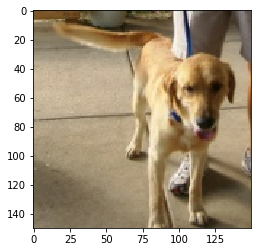

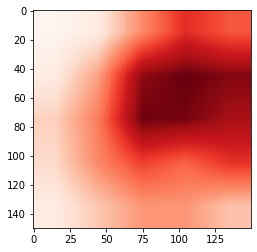

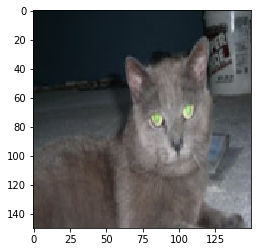

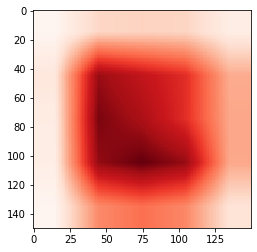

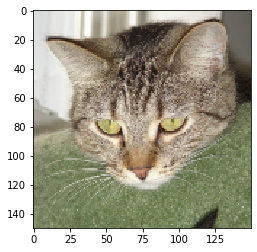

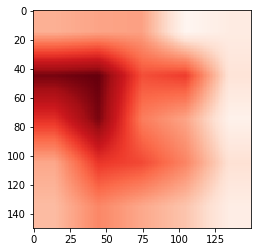

In [13]:
for x, y in test_databatch.take(3):
    sample_img = x[0]
    sample_img = tf.expand_dims(sample_img, axis=0)
    
    feature = feat_ext(sample_img)[0]
    result = model1(sample_img)[0]
    display_cam(sample_img[0], feature, result)

In [14]:
import numpy as np
train_img = np.random.randn(3200, 32, 32, 1)
train_img.shape

(3200, 32, 32, 1)

In [15]:
train_x = train_img.reshape(800, 4, 32, 32)
train_x = np.rollaxis(train_x, 1, 4)
train_x.shape

(800, 32, 32, 4)

In [16]:
train_img[:4].mean(), train_x[0].mean()

(0.006577150942216928, 0.006577150942216928)

In [17]:
train_img[0].mean()==train_x[0,:,:,0].mean(), train_img[3].mean()==train_x[0,:,:,3].mean()

(True, True)

In [18]:
inp = Input(shape=(32, 32, 4))
x = Conv2D(12, 7, padding='same')(inp)

x1 = Conv2D(8, 5, padding='same')(x)
x1 = AveragePooling2D(strides=1, padding='same')(x1)
x1 = Conv2D(8, 5, padding='same')(x1)

x2 = Conv2D(6, 3, padding='same')(x)
x2 = AveragePooling2D(strides=1, padding='same')(x2)
x2 = Conv2D(6, 3, padding='same')(x2)

x = Concatenate(axis=-1)([x1, x2])
x = GlobalAveragePooling2D()(x)
x = Dense(10)(x)
out = Dense(1, activation='relu')(x)
model2 = Model(inp, out)
model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 4)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 12)   2364        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 8)    2408        conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 32, 32, 6)    654         conv2d[0][0]                     
____________________________________________________________________________________________

In [19]:
model2.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')
#model2.fit(train_x, train_y, epochs=3)

In [20]:
feat1 = np.random.randn(800, 1)
feat2 = np.random.randn(800, 1)
feat3 = np.random.randn(800, 1)
feat4 = np.random.randn(800, 1)
feat5 = np.random.randn(800, 1)
feat6 = np.random.randn(800, 1)
feat1.shape, feat2.shape, feat3.shape, feat4.shape, feat5.shape, feat6.shape

((800, 1), (800, 1), (800, 1), (800, 1), (800, 1), (800, 1))

In [21]:
inp1 = Input(shape=(32, 32, 4))
x1 = Conv2D(12, 7, padding='same')(inp1)

inp2 = Input(shape=(6))
x2 = Dense(4)(inp2)
x2 = Dense(4)(x2)
x2 = tf.keras.layers.Reshape((1, 1, 4))(x2)
x2 = tf.keras.layers.UpSampling2D((32, 32))(x2)

x = Concatenate(axis=-1)([x1, x2])

x1 = Conv2D(8, 5, padding='same')(x)
x1 = AveragePooling2D(strides=1, padding='same')(x1)
x1 = Conv2D(8, 5, padding='same')(x1)

x2 = Conv2D(6, 3, padding='same')(x)
x2 = AveragePooling2D(strides=1, padding='same')(x2)
x2 = Conv2D(6, 3, padding='same')(x2)

x = Concatenate(axis=-1)([x1, x2])
x = GlobalAveragePooling2D()(x)
x = Dense(10)(x)
out = Dense(1, activation='relu')(x)
model3 = Model([inp1, inp2], out)
model3.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 4)            28          input_5[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 4)            20          dense_3[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 32, 32, 4)]  0                                            
____________________________________________________________________________________________

In [22]:
model3.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')
#model3.fit([train_x, train_feat], )

In [23]:
from tensorflow.keras.layers import Embedding

In [24]:
inp = Input(shape=(None, 6))

x1 = Embedding(841, 30)(inp[:, :, 0])
x2 = Embedding(243, 30)(inp[:, :, 1])
x3 = Embedding(90, 30)(inp[:, :, 2])
x4 = Embedding(78, 30)(inp[:, :, 3])
x5 = tf.expand_dims(inp[:, :, 4]/120, axis=-1) # 0~120 범위일 때 0~1로 Normalize
x6 = tf.expand_dims((inp[:, :, 5] - 60)/120, axis=-1) ## 60~180 범위일 때 0~1로 Normalize

x = Concatenate(axis=-1)([x1, x2, x3, x4, x5, x6])
x = Dense(10)(x)
out = Dense(2, activation='softmax')(x)
model4 = Model(inp, out)
model4.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, None, 6)]    0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_5 (Sli (None, None)         0           input_6[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_4 (Sli (None, None)         0           input_6[0][0]                    
__________________________________________________________________________________________________
tf.math.subtract (TFOpLambda)   (None, None)         0           tf.__operators__.getitem_5[0][0] 
____________________________________________________________________________________________

In [25]:
callback1 = tf.keras.callbacks.ModelCheckpoint('./custom_model.h5', monitor='val_acc', save_best_only=True, save_freq=10)
callback2 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

In [26]:
custom_callback = [callback1, callback2]
# model4.fit(callbacks=custom_callback)

In [27]:
class MY_CB(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        keys = list(logs.keys())
        print('Start training; got log keys: {}'.format(keys))
        
    def on_train_end(self, logs=None):
        keys = list(logs.keys())
        print('Stop training; got log keys: {}'.format(keys))
        
    def on_epoch_begin(self, epoch, logs=None):
        keys = list(logs.keys())
        print('Start epoch {} of training; got log keys: {}'.format(epoch, keys))
        
    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        print('End epoch {} of training; got log keys: {}'.format(epoch, keys))
        
    def on_test_begin(self, logs=None):
        keys = list(logs.keys())
        print('Start testing; got log keys: {}'.format(keys))
        
    def on_test_end(self, logs=None):
        keys = list(logs.keys())
        print('Stop testing; got log keys: {}'.format(keys))
        
    def on_predict_begin(self, logs=None):
        keys = list(logs.keys())
        print('Start predicting; got log keys: {}'.format(keys))
        
    def on_predict_end(self, logs=None):
        keys = list(logs.keys())
        print('Stop training; got log keys: {}'.format(keys))
        
    def on_train_batch_begin(self, batch, logs=None):
        keys = list(logs.keys())
        print('...Training; Start of batch {}; got log keys: {}'.format(batch, keys))
        
    def on_train_batch_end(self, batch, logs=None):
        keys = list(logs.keys())
        print('...Training; End of batch {}; got log keys: {}'.format(batch, keys))
        
    def on_test_batch_begin(self, batch, logs=None):
        keys = list(logs.keys())
        print('...Evaluating; Start of batch {}; got log keys: {}'.format(batch, keys))
        
    def on_test_batch_end(self, batch, logs=None):
        keys = list(logs.keys())
        print('...Evaluating; End of batch {}; got log keys: {}'.format(batch, keys))
        
    def on_predict_batch_begin(self, batch, logs=None):
        keys = list(logs.keys())
        print('...Predicting; Start of batch {}; got log keys: {}'.format(batch, keys))
        
    def on_predict_batch_end(self, batch, logs=None):
        keys = list(logs.keys())
        print('...Predicting; End of batch {}; got log keys: {}'.format(batch, keys))
